# Python機械学習 勉強会 第八回「教師なし学習2」

参考文献：  
Pythonではじめる機械学習　3章  
https://github.com/amueller/introduction_to_ml_with_python/blob/master/03-unsupervised-learning.ipynb

scikit-learnドキュメント：  
https://scikit-learn.org/stable/documentation.html

In [1]:
%matplotlib inline
from preamble import *
from sklearn.model_selection import train_test_split
plt.rcParams['image.cmap'] = "gray"

<br>

---

## はじめに

今回は以下の内容を取り組む

* 次元削減、特徴量抽出、多様体学習
    * 主成分分析(PCA)
    * 非負値行列因子分解(NMF)
    * t-SNE

<br>

---

## 3 教師なし学習と前処理
### 3.4 次元削減、特徴量抽出、多様体学習
#### 3.4.1 主成分分析(PCA)

##### 3.4.1.2 固有顔による特徴量抽出
PCAには、次元削減だけでなく特徴量抽出という利用方法がある。  
これは、データには与えられたもとの表現よりも解析に適した表現があり、それを見つけることができる、ということ。

<br>

具体的に画像からの特徴量抽出を見てみる。

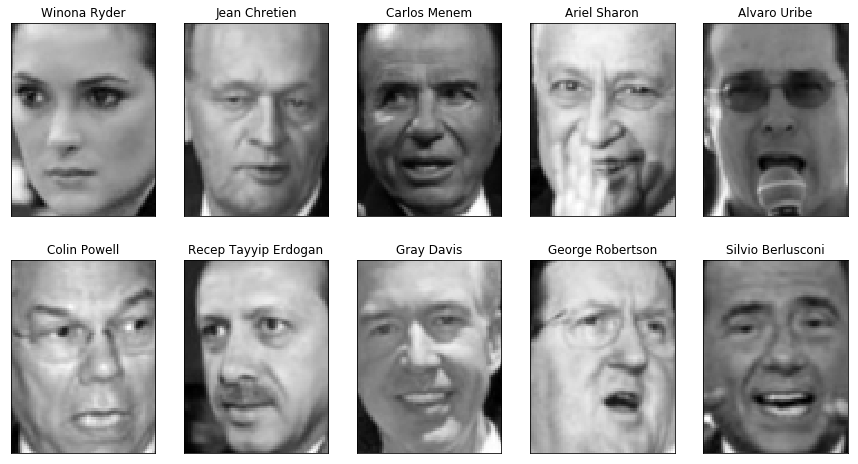

In [2]:
from sklearn.datasets import fetch_lfw_people
people = fetch_lfw_people(data_home='./data', min_faces_per_person=20, resize=0.7, download_if_missing=False)
image_shape = people.images[0].shape

fig, axes = plt.subplots(2, 5, figsize=(15, 8),
                         subplot_kw={'xticks': (), 'yticks': ()})
for target, image, ax in zip(people.target, people.images, axes.ravel()):
    ax.imshow(image)
    ax.set_title(people.target_names[target])

In [3]:
print("people.images.shape: {}".format(people.images.shape))
print("Number of classes: {}".format(len(people.target_names)))

people.images.shape: (3023, 87, 65)
Number of classes: 62


<br>

このデータセットは、インターネットから収集した有名人の顔画像で構成されている。  
ここでは条件をしぼった結果、計62人、87x65ピクセルの画像が3023枚のセットで試すが、  
このままでは各人の画像数のばらつきに左右されるので、各人の画像数を最大50枚に制限する。

In [5]:
mask = np.zeros(people.target.shape, dtype=np.bool)
for target in np.unique(people.target):
    mask[np.where(people.target == target)[0][:50]] = 1
    
X_people = people.data[mask]
y_people = people.target[mask]

# グレースケールの値は0～255で表現されているので、
# 0～1の間にスケール変換する
X_people = X_people / 255.

In [6]:
print("X_people shape: {}".format(X_people.shape))
print("y_people shape: : {}".format(y_people.shape))

X_people shape: (2063, 5655)
y_people shape: : (2063,)


特徴量5655(87x65=5655ピクセル)、2063画像のデータセットになった。

<br>

ここで顔認識の一般的なタスクを試してみる。  
まずは簡単な方法としてk最近傍法クラス分類器を使う。

In [7]:
from sklearn.neighbors import KNeighborsClassifier
# 訓練セットとテストセットに分割
X_train, X_test, y_train, y_test = train_test_split(
    X_people, y_people, stratify=y_people, random_state=0)

# KNeighborsClassifier で1最近傍法モデルを構築
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
print("Test set score of 1-nn: {:.2f}".format(knn.score(X_test, y_test)))

Test set score of 1-nn: 0.23


<br>

ここでの精度は23%だった。  
まったくのランダム(1/62=1.5%)よりはマシだが、精度がいいとは言えない。

これは、顔の近似度の計算において、もとのピクセル空間上で距離を測ることが適していないからである。  
* 1ピクセル右にずらすだけで表現が変化してしまう

そこでPCAを用いて、主成分に沿った距離を使うことを検討する。

<br>

ここでは***whiten***オプションを使ってみる。  
これを用いると、主成分が同じスケールになるように変換される。
* PCAによる変換後に***StandardScaler***をかけるのと同じ


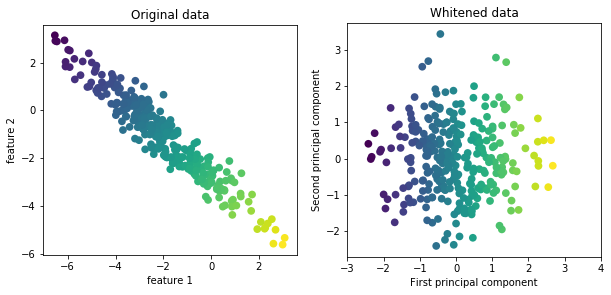

In [7]:
mglearn.plots.plot_pca_whitening()

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=100, whiten=True, random_state=0).fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

print("X_train_pca.shape: {}".format(X_train_pca.shape))

X_train_pca.shape: (1547, 100)


***n_components***で指定した通り、100の主成分で構成された特徴量に変換した。  
この新しい表現を使って、再度k-NNを試す。

In [9]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_pca, y_train)
print("Test set accuracy: {:.2f}".format(knn.score(X_test_pca, y_test)))

Test set accuracy: 0.31


<br>

精度が向上した。  
これは、データの表現をもとのピクセルから主成分に変えることで、  
より画像の特徴を捉えられたことを意味する。

<br>

画像データについては、見つけた主成分を可視化することが容易である。

最初のいくつかの主成分をチェックしてみる。

In [10]:
print("pca.components_.shape: {}".format(pca.components_.shape))

pca.components_.shape: (100, 5655)


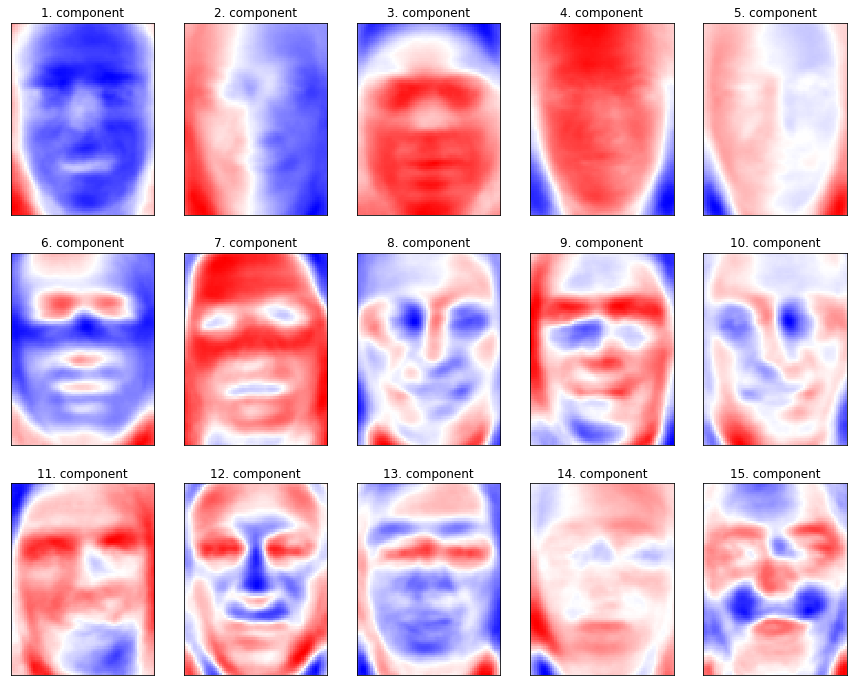

In [11]:
fig, axes = plt.subplots(3, 5, figsize=(15, 12),
                         subplot_kw={'xticks': (), 'yticks': ()})
for i, (component, ax) in enumerate(zip(pca.components_, axes.ravel())):
    ax.imshow(component.reshape(image_shape),
              cmap='bwr')
    ax.set_title("{}. component".format((i + 1)))

<br>

これらは、各主成分ごとに画像のどこに注目しているか、という解釈ができる。  

例えば、1つめは「顔と背景のコントラスト」、2つめは「光の当たり方による顔の左右の明るさの差」など。

しかし、これらは人間が認識する際の判断とは異なるはずであり、  
機械学習アルゴリズムがデータを解釈する方法は、多くの場合人間とはまったく違うということを覚えておこう。

<br>

なお、各主成分をもとに画像を復元することもできる。
これは、画像はPCAの各主成分の重み付き和として表現されるからだ。

ここで、いくつかの主成分をもとに画像を復元した例を示す。

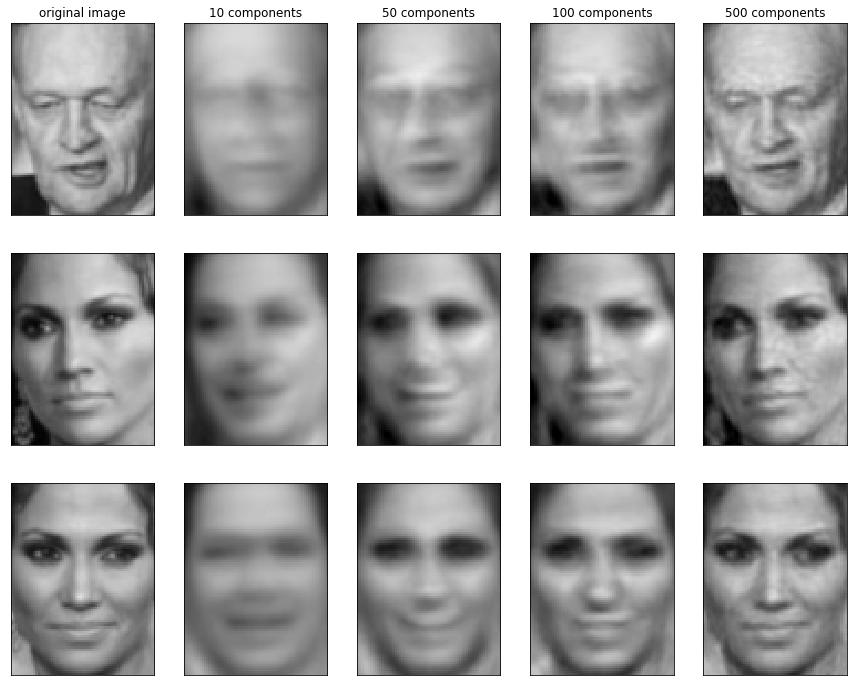

In [12]:
mglearn.plots.plot_pca_faces(X_train, X_test, image_shape)

10主成分だけでは、画像の概要しかわからないことがわかる。

最初の2つの主成分を用いて散布図をプロットしてみる。  
クラスは画像の人間である。

Text(0, 0.5, 'Second principal component')

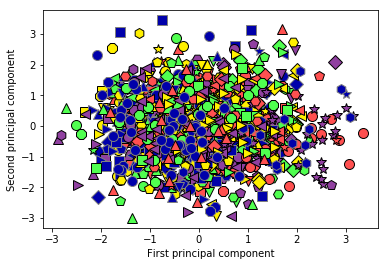

In [13]:
mglearn.discrete_scatter(X_train_pca[:, 0], X_train_pca[:, 1], y_train)
plt.xlabel("First principal component")
plt.ylabel("Second principal component")

この図を見ても、最初の2つの主成分だけではデータ全体が固まってしまい、  
うまくクラスを分離できそうにないことが分かる。

PCAを用いてデータの表現を変える際は、主成分の数に注意する必要がある。

<br>

#### 3.4.2 非負値行列因子分解(NMF)

非負値行列因子分解(Non-negative matrix factorization: NMF)も、  
特徴量を抽出することができる教師なし学習手法である。

NMFではその名の通り、成分と係数が常に0以上となるように、データを分解する。  
つまり、個々の特徴量が非負のデータにしか適用できない。

<br>

NMFは、いくつもの独立した発生源から得られたデータを重ね合わせて作られたデータに有効だ。  
* 複数の人が話している音声データ
* 多数の楽器からなる音楽

<br>

##### 3.4.2.1 NMFの合成データへの適用
簡単な合成データでNMFを確認する。

NMFでは0以上の値である必要がある。  
したがって、NMFによって抽出された成分は、原点からデータへの方向だと考えることができる。

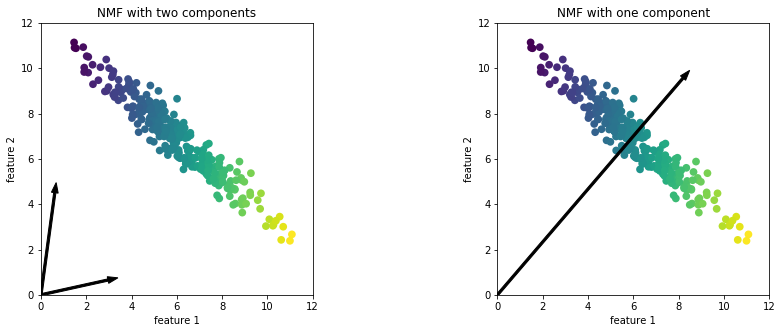

In [14]:
mglearn.plots.plot_nmf_illustration()

図は2次元のデータにNMFを適用した例であり、  
左側は2成分のNMFで表現しており、右側は1つの成分しか使っていない。

左側のように、特徴量と同じだけの成分で表現=完全にもとのデータを再現できる場合、  
NMFで抽出した成分はデータの極端な部分の方向を向く。

右側のように1つしか使わない場合は、データの平均値へ向かう成分を作る。  
この点が最もよくデータを説明するからである。

<br>

##### 3.4.2.2 NMFの顔画像への適用
ここで、NMFを顔画像分類に適用してみる。

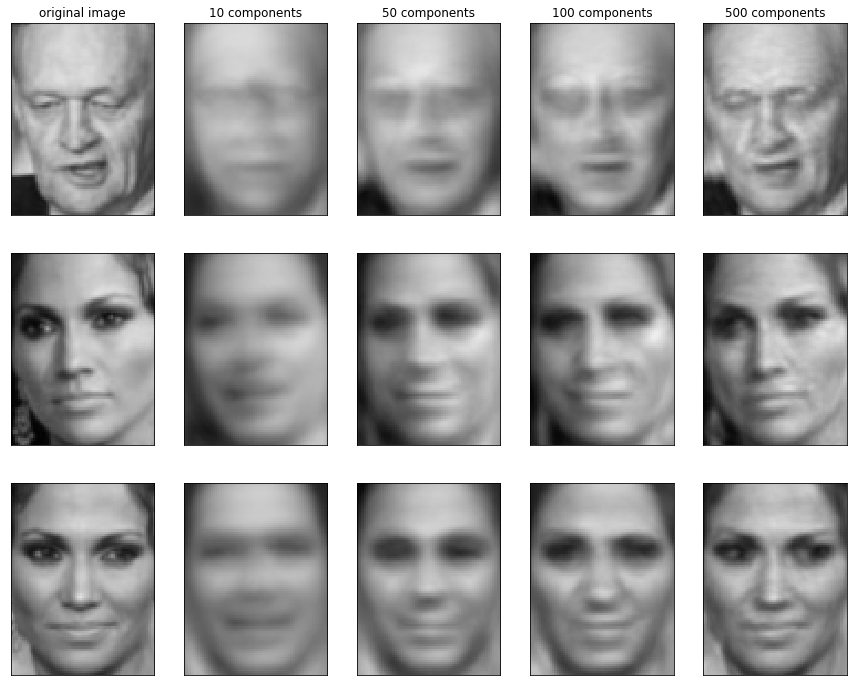

In [15]:
mglearn.plots.plot_nmf_faces(X_train, X_test, image_shape)

逆変換した結果、PCAの時と似たような傾向だが、少し質が悪い。  
PCAは再構成に最適な方向を見つけるので、これは想定通りである。

NMFは再構成やデータのエンコードに用いられるよりは、データ中から興味深いパターンを見つけるのに用いられる。

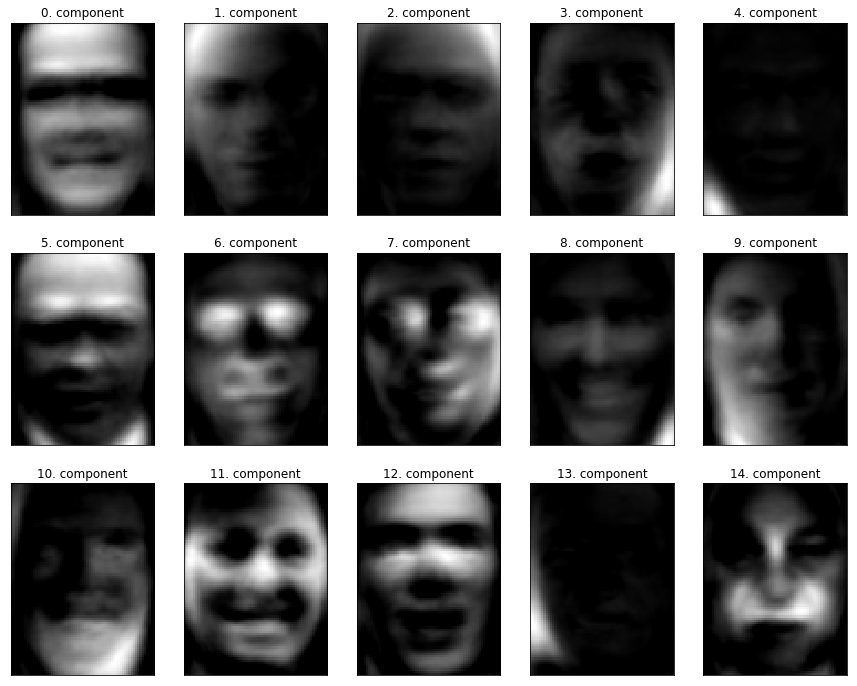

In [16]:
from sklearn.decomposition import NMF
nmf = NMF(n_components=15, random_state=0)
nmf.fit(X_train)
X_train_nmf = nmf.transform(X_train)
X_test_nmf = nmf.transform(X_test)

fig, axes = plt.subplots(3, 5, figsize=(15, 12),
                         subplot_kw={'xticks': (), 'yticks': ()})
for i, (component, ax) in enumerate(zip(nmf.components_, axes.ravel())):
    ax.imshow(component.reshape(image_shape))
    ax.set_title("{}. component".format(i))

最初の15成分を見てみた結果、PCAよりも顔の形を捉えられていることがわかる。  
これは成分がすべて正であるため。

このようなパターン抽出は、音声データや遺伝子発現、テキストデータなどの  
追加していく構造をもつデータに対して最もよく機能する。

<br>

ここで、合成データセットで確認してみる。

Text(0, 0.5, 'Signal')

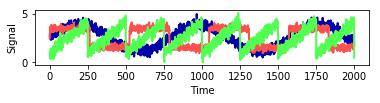

In [17]:
S = mglearn.datasets.make_signals()
plt.figure(figsize=(6, 1))
plt.plot(S, '-')
plt.xlabel("Time")
plt.ylabel("Signal")

このデータでは3つの信号が存在するが、これらが混ざった信号を分解してもとの成分を取り出すことを試してみる。

ここでは混ざった信号を計測する手段が100あったとして計測結果を作ってみる。

In [18]:
# Mix data into a 100 dimensional state
A = np.random.RandomState(0).uniform(size=(100, 3))
X = np.dot(S, A.T)
print("Shape of measurements: {}".format(X.shape))

Shape of measurements: (2000, 100)


<br>

計測結果をもとにNMFで成分を分解する。  
比較としてPCAでも行ってみる。

In [19]:
nmf = NMF(n_components=3, random_state=42)
S_ = nmf.fit_transform(X)
print("Recovered signal shape: {}".format(S_.shape))

Recovered signal shape: (2000, 3)


In [20]:
pca = PCA(n_components=3)
H = pca.fit_transform(X)

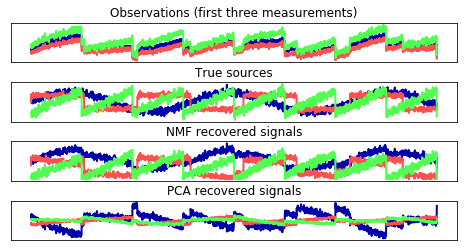

In [21]:
models = [X, S, S_, H]
names = ['Observations (first three measurements)',
         'True sources',
         'NMF recovered signals',
         'PCA recovered signals']

fig, axes = plt.subplots(4, figsize=(8, 4), gridspec_kw={'hspace': .5},
                         subplot_kw={'xticks': (), 'yticks': ()})

for model, name, ax in zip(models, names, axes):
    ax.set_title(name)
    ax.plot(model[:, :3], '-')

NMFはもとの信号源をうまく特定できていることが分かる。  
一方でPCAは第1主成分をデータの大きな変動を説明するのに使っており、信号源の特定に失敗している。

つまり、このようなタスクにおいてはPCAよりNMFの方が適していることが分かる。

<br>

PCAやNMF以外にも、データを成分集合の重み付き和に分解するアルゴリズムは多数ある。  
ここでは紹介しないが、興味ある場合はscikit-learnのドキュメントをチェックして欲しい。

https://scikit-learn.org/stable/modules/decomposition.html

<br>

#### 3.4.3 t-SNEを用いた多様体学習

データを変換して可視化したいときには、PCAを使うよりも多様体学習というアルゴリズムが適している。  
その中でも有用なのたt-SNEアルゴリズムである。

多様体学習は、訓練データを新たな表現にできるが、新しいデータを変換することはできない。  
そのため、探索的なデータ解析(EDA)などには有用だが、最終的なアプリケーションに組み込まれることはない。

<br>

t-SNEは、データポイントの距離を、可能な限り維持する2次元表現を見つける。  
つまり、どの点が近傍か示す情報を維持しようとする。

手書き数字データセット(digitsデータセット)に適用してみる。

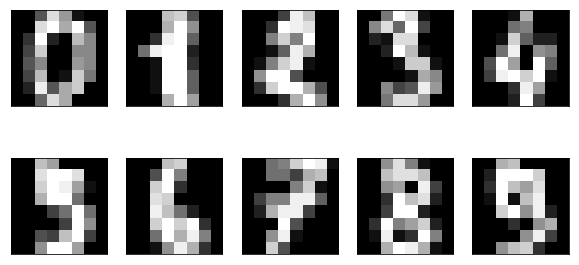

In [22]:
from sklearn.datasets import load_digits
digits = load_digits()

fig, axes = plt.subplots(2, 5, figsize=(10, 5),
                         subplot_kw={'xticks':(), 'yticks': ()})
for ax, img in zip(axes.ravel(), digits.images):
    ax.imshow(img)

このデータセットは、8x8のグレースケールで表現される、0～9までの手書き数字である。

比較のため、最初にPCAを使って2次元に可視化してみる。

Text(0, 0.5, 'Second principal component')

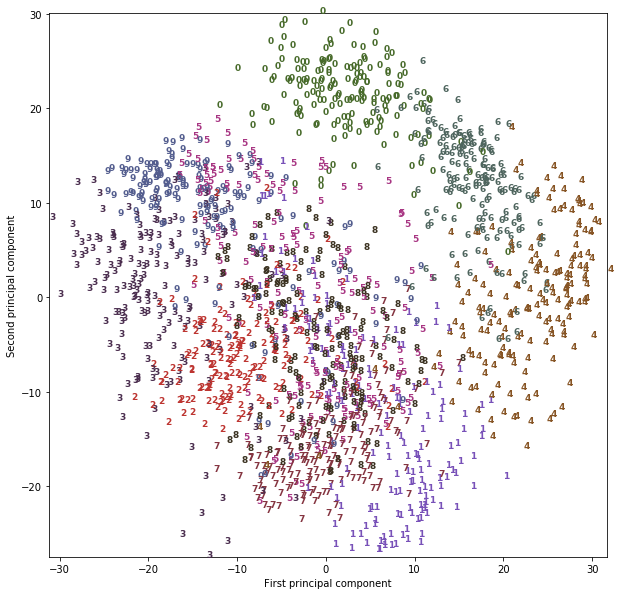

In [23]:
# PCAモデルを構築
pca = PCA(n_components=2)
pca.fit(digits.data)

# 数値データを最初に2主成分で変形
digits_pca = pca.transform(digits.data)
colors = ["#476A2A", "#7851B8", "#BD3430", "#4A2D4E", "#875525",
          "#A83683", "#4E655E", "#853541", "#3A3120", "#535D8E"]
plt.figure(figsize=(10, 10))
plt.xlim(digits_pca[:, 0].min(), digits_pca[:, 0].max())
plt.ylim(digits_pca[:, 1].min(), digits_pca[:, 1].max())
for i in range(len(digits.data)):
    # 散布図を数字でプロット
    plt.text(digits_pca[i, 0], digits_pca[i, 1], str(digits.target[i]),
             color = colors[digits.target[i]],
             fontdict={'weight': 'bold', 'size': 9})
plt.xlabel("First principal component")
plt.ylabel("Second principal component")

0, 6, 4は比較的分離できそうだが、残りは重なりあっている。

ここで、同じデータを用いてt-SNEで表現してみる。

In [24]:
from sklearn.manifold import TSNE
tsne = TSNE(random_state=42)
# use fit_transform instead of fit, as TSNE has no transform method
digits_tsne = tsne.fit_transform(digits.data)

Text(0, 0.5, 't-SNE feature 1')

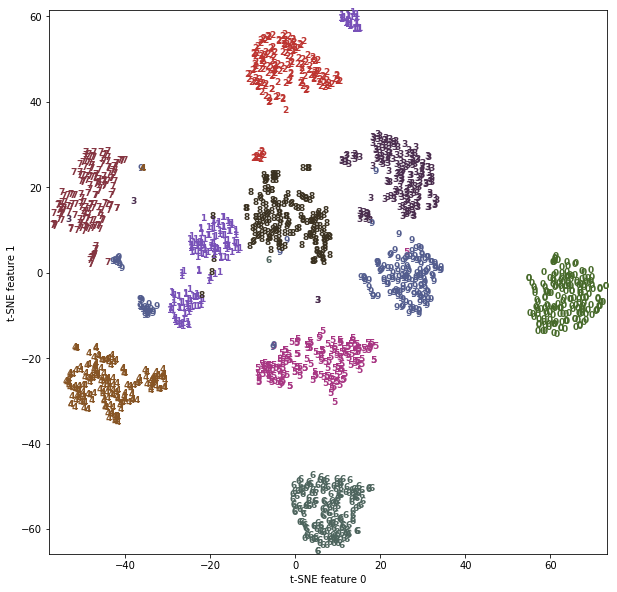

In [25]:
plt.figure(figsize=(10, 10))
plt.xlim(digits_tsne[:, 0].min(), digits_tsne[:, 0].max() + 1)
plt.ylim(digits_tsne[:, 1].min(), digits_tsne[:, 1].max() + 1)
for i in range(len(digits.data)):
    # 点ではなく数字をテキストとしてプロットする
    plt.text(digits_tsne[i, 0], digits_tsne[i, 1], str(digits.target[i]),
             color = colors[digits.target[i]],
             fontdict={'weight': 'bold', 'size': 9})
plt.xlabel("t-SNE feature 0")
plt.ylabel("t-SNE feature 1")

クラスがかなり明確に分離されている。

これは教師なし学習なので、クラスラベル(0～9)という情報を使っていない。  
もとの空間の点の近さだけを使って、この表現を実現している。

<br>

---

## おわり

誤字脱字、不明点あればご連絡ください。